<h1>Neighborhood Prediction</h1>

In [ ]:
# For reproducibility
import random
import numpy as np
r_state = 42
random.seed(r_state) 
np.random.seed(r_state)

import os
import re
import pandas as pd
import seaborn as sns

import sklearn

from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn import tree
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics  
from sklearn import ensemble

import statsmodels.api as sm
from scipy import stats

#from sklearn.externals.six import StringIO
#from sklearn.model_selection import GridSearchCV
#from sklearn.feature_selection import SelectKBest 
#from sklearn.feature_selection import f_regression

from timeit import default_timer as timer
import datetime

In [ ]:
def load_status_scores(dtype):
    status = pd.read_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/04-Neighborhood Scores/scores'+ to_use + '.csv', index_col=0)  # SES scores
    
    # Scores
    status.dropna(inplace = True)
    
    status.drop(['RANK_10','RANK_19'], axis=1, inplace=True)
    status.rename(columns={
        'SES_10':'SES 2010',
        'SES_19':'SES 2019',
        'SES_ASC':'SES Ascent 2010-2019',
        'SES_PR_10':'SES 2010 Percentile', # 99 = High-status
        'SES_PR_19':'SES 2019 Percentile', # 99 = High-status
        'SES_PR_ASC':'SES Percentile Ascent 2010-2019'
    }, inplace=True)
    return status

def load_predictors(dtype):
    
    return status

def classifier_report(clf, y_true, y_hat):
    
    txt = ''
    
    # If the task is regression evaluate using regression metrics, 
    # otherwise evaluate using classification metrics
    txt += "R2:        {0:8.5f}".format(metrics.r2_score(y_true, y_hat)) + "\n" #  R2 - Coefficient of determination
    txt += "MSE:       {0:8.5f}".format(metrics.mean_squared_error(y_true, y_hat)) + "\n"  #  Mean squared error regression loss
    txt += "MAE:       {0:8.5f}".format(metrics.mean_absolute_error(y_true, y_hat)) + "\n"  #  Mean absolute error regression loss
    txt += "Expl. Var: {0:8.5f}".format(metrics.explained_variance_score(y_true, y_hat)) + "\n"  # Explained variance regression score function
    txt += "\n"
    
    #print(metrics.accuracy_score(y_true, y_pred))  #  Accuracy Score
    #print(metrics.classification_report(y_true, y_pred, target_names=["Unascended","Ascended"]))  #  Classification Report
    #print(metrics.confusion_matrix(y_true, y_pred))  #  Confusion Matrix
    #print()
    return txt

<h2>Information About Variable Utility</h2>
<p>The section below uses the F-Regression in Scikit-Learn to evaluate the significance of each variable. The results are sorted in ascending order. In the random forest regression the algorithm will perform its own feature reflection; however, this analysis gives us information about the utility of each variable in linear models. It's important to note that Random Forest Regressions are NOT linear models.</p>

In [ ]:
# Can override to_use here if have already generated data above
to_use = 'Untransformed'

SES = load_status_scores(to_use)  

#  Read the transformed data
d10_trs2 = pd.read_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/05-Transformed and Scaled Data/TransformedAndScaled2010' + to_use + '.csv', index_col=0)
d19_trs2 = pd.read_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/05-Transformed and Scaled Data/TransformedAndScaled2019' + to_use + '.csv', index_col=0)

In [ ]:
kb = feature_selection.SelectKBest(feature_selection.f_regression, k='all')             #  Evaluate f-regression to evaluate all variables
kb.fit(d10_trs2, SES.loc[:,'SES Ascent 2010-2019']) #  Pass variable data from 2010 to find correlation with SES 19

# Check this!!!
print("Max f-test value: " + str(np.max(kb.scores_)))
f_test = kb.scores_
p_vals = kb.pvalues_
f_test /= np.max(f_test) # Normalise by maximum value (http://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html)

In [ ]:
#  Format results and write to file
results = pd.DataFrame(data=f_test, index=d10_trs2.columns)
results.reset_index(inplace=True)
results.columns = ['Predictor','Score']
results.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/' + to_use + 'f_test results.csv', index=False)

pvals = pd.DataFrame(data=p_vals, index=d10_trs2.columns)
pvals.reset_index(inplace=True)
pvals.columns = ['Predictor','P-val']
pvals.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/' + to_use + 'p_values f_test results.csv', index=False)
# Results are...
results.sort_values(by='Score', ascending=False).head(5)

<p><b>Results (Predictor, Score):</b><br>
Percentage with Bachelor Degree or Higher, 1.000000 <br>
House Prices, 0.994740 <br>
Percentage Professional Workers, 0.797119 <br>
privateVehicle, 0.496796 <br>
subwayTram, 0.452111</p>

<h2>Developing the Models</h2>

In [ ]:
# Can override to_use here
to_use = 'Untransformed'

SES = load_status_scores(to_use)  

#  Read the transformed data
d10_trs2 = pd.read_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/05-Transformed and Scaled Data/TransformedAndScaled2010' + to_use + '.csv', index_col=0)
d19_trs2 = pd.read_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/05-Transformed and Scaled Data/TransformedAndScaled2019' + to_use + '.csv', index_col=0)

<p>Split the data into testing and training sets with a test size of 20%</p>

In [ ]:
X_full = d10_trs2

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    d10_trs2, SES['SES Ascent 2010-2019'], test_size=0.2, random_state=r_state)

In [ ]:
d10_trs2.shape

In [ ]:
SES.shape

In [ ]:
log = open('/Users/ritalaplante/Desktop/Thesis Data and Analytics/09-Logged Outputs/'+to_use+'-Fit.txt','w')
print("Data Transform: " + to_use, file=log)
print("", file=log)

<h2>Simple Linear Regression</h2>
<p>One rule modelling using a stochastic loss gradient to build an SLR estimator using each variable separately.</p>

In [ ]:
#  Evaluate each predictor using simple linear regression
preds_ls = list(d10_trs2.columns)  #  List of predictors
df = pd.DataFrame(X_train, columns=d10_trs2.columns)
results_dict = dict()  #  Store results here

#  Loop over each predictor and evaluate it's performance
for p in preds_ls:
    #print("Evaluating: " + p)
    #X_sing = df[p].as_matrix()  #  Get predictor data from dataset   
    clf = linear_model.SGDRegressor(loss='squared_loss', penalty=None, random_state=r_state, max_iter=1000, tol=1e-3) #  Build Stochastic Gradient Descent estimator
    clf.fit(X_train[[p]],y_train)
    y_pred = clf.predict(X_test[[p]])
    sc  = metrics.r2_score(y_test, y_pred, multioutput='variance_weighted')
    mse = metrics.mean_squared_error(y_test, y_pred)  #  Mean squared error regression loss
    mae = metrics.mean_absolute_error(y_test, y_pred)  #  Mean absolute error regression loss
    var = metrics.explained_variance_score(y_test, y_pred)  # Explained variance regression score function
    
    results_dict[p] = [sc, mse, mae, var] 

results = pd.DataFrame.from_dict(results_dict, orient='index').sort_values(by=0, ascending=False)
results.reset_index(inplace=True)
results.columns = ['Predictor','R2-Score','MSE','MAE','Explained Variance']
results.sort_values(by=['R2-Score'], ascending=False, inplace=True)
results.head(5)

<p><b>Results (Predictor, R2-Score, MSE, MAE, Explained Variance):</b><br>
Percentage with Bachelor Degree or Higher (0.399285, 0.218629, 0.366882, 0.400542)<br>
House Prices (0.364261, 0.231377, 0.382195, 0.368736)<br>
Percentage Professional Workers	(0.346837, 0.237718, 0.390854, 0.347368)<br>
subwayTram	(0.223965, 0.282437, 0.422990, 0.224298)<br>
privateVehicle (0.186989, 0.295894, 0.420411, 0.187005)</p>


In [ ]:
# And for logging purposes
p   = results['Predictor'].iloc[0]
print(p)
clf = linear_model.SGDRegressor(loss='squared_loss', penalty=None, random_state=r_state, max_iter=1000, tol=1e-3)
clf.fit(X_train[[p]],y_train)
y_pred = clf.predict(X_test[[p]])

print("Singular Regression results:")
print(classifier_report(clf, y_test, y_pred), file=log)
print(classifier_report(clf, y_test, y_pred)) # clf, y_test, y_hat
print("", file=log)
log.close()

<h2>Multiple Regression</h2>
<p>Ordinary Least Squares Regression on testing and training data.</p>

In [ ]:
clf = linear_model.LinearRegression(fit_intercept=True, copy_X=True)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(classifier_report(clf, y_test, y_pred))

<p><b>Results:</b><br>
R2: 0.46826 <br>
MSE: 0.19353 <br>
MAE: 0.34024 <br>
Expl. Var: 0.46983</p>


In [ ]:
log = open('/Users/ritalaplante/Desktop/Thesis Data and Analytics/09-Logged Outputs/'+to_use+'-Fit.txt','a')
print("Multiple Regression results:", file=log)
print(classifier_report(clf, y_test, y_pred), file=log)
print(classifier_report(clf, y_test, y_pred))
print("", file=log)
log.close()

<h2>Making Predictions</h2>
<p>Uses Extremely Random Trees to predict the entirety of the 2019 dataset. In separate .py GridSearchCV is used to search over all parameters for the Extra Trees Regressor. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.</p>
<p>The best classification model based on the results of the Grid Search is specified below.</p>
<p>The difference between Extremely Random Trees (Extra Trees Regressor) and Random Forests can be found in the image below (this image was taken from <a>https://stats.stackexchange.com/questions/175523/difference-between-random-forest-and-extremely-randomized-trees</a>)</p>

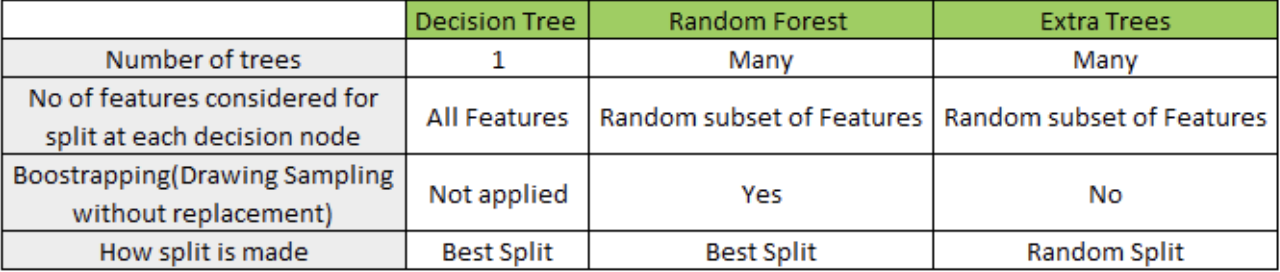

<p>In an Extra Trees Regression randomness comes from random splits of all observations rather than bootstrapping. I found that using this analysis compared to a random forest yielded less variation in my output.</p>

<h2>Extra Trees Regressor</h2>

In [ ]:
etr_clf = ensemble.ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=0.65, max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=-1,
          oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
etr_clf.fit(X_train, y_train)
y_pred  = etr_clf.predict(X_test)

In [ ]:
print("Cross-check against full spec of model: ")
print(etr_clf.get_params)
print("")

print("Tuned Extra Trees result:")
print(classifier_report(etr_clf, y_test, y_pred))
print("")

<p><b>Tuned Extra Trees Result:</b><br>
R2: 0.52544 <br>
MSE: 0.17272 <br>
MAE: 0.32392 <br>
Expl. Var: 0.52722</p>

<h3>Export Random Forest Results as Visualization</h3>

In [ ]:
estimator = etr_clf.estimators_[0]
feature_names = X_test.columns.values

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:
# Create a data frame of feature importance so that we
# can inspect later...
fi = pd.DataFrame.from_dict({'feature':X_test.columns.values, 'importance':etr_clf.feature_importances_})

fi.sort_values(by='importance', ascending=False, inplace=True)
fi.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/FeatureImportance' + to_use + 'ETR.csv', index=False)

print("Feature Importances (5 Biggest):")
print(fi.head(5))

<p><b>Feature Importance (5 Biggest) (feature, importance):</b><br>
House Prices, 0.105607<br>
Percentage with Bachelor Degree or Higher, 0.081191<br>
Percentage Professional Workers, 0.050712<br>
privateVehicle, 0.045524<br>
subwayTram, 0.044937</p>
<p>The top 10 most important features were (in order): House Prices, Percentage with a Bachelor's Degree or Higher, Percentage of Professional Workers, Private Vehicle, subwayTram, children, walked, detached_1, bicycle, white.</p>
<p>These results seem to indicate that house price, education, occupation, race, transportation to work, age, and building structure all play an important role in predicting gentrification in the Greater Boston area.</p>
<p>Feature Importance can tell us what variables are relevant in this model. However, feature importance does not define a specific/interpretable relationship between features.</p>

<h2>Random Forest Regressor</h2>

In [ ]:
rf_clf = ensemble.RandomForestRegressor(max_depth=100, max_features=0.5, n_estimators=1400, n_jobs=-1, random_state=42)

In [ ]:
rf_clf.fit(X_train, y_train)
y_pred  = rf_clf.predict(X_test)

In [ ]:
print("Cross-check against full spec of model: ")
print(rf_clf.get_params)
print("")

print("Tuned Extra Trees result:")
print(classifier_report(rf_clf, y_test, y_pred))
print("")

<p><b>Tuned Random Forest result:</b><br>
R2:         0.53334<br>
MSE:        0.16984<br>
MAE:        0.31946<br>
Expl. Var:  0.53470</p>

<h3>Export Random Forest Results as Visualization</h3>

In [ ]:
estimator = rf_clf.estimators_[0]
feature_names = X_test.columns.values

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:
# Create a data frame of feature importance so that we
# can inspect later...
fi = pd.DataFrame.from_dict({'feature':X_test.columns.values, 'importance':rf_clf.feature_importances_})

fi.sort_values(by='importance', ascending=False, inplace=True)
fi.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/FeatureImportance' + to_use + 'RF.csv', index=False)

print("Feature Importances (5 Biggest):")
print(fi.head(5))

<p><b>Feature Importances (5 Biggest) (feature, importance):</b><br>
House Prices    0.143421<br>
Percentage with Bachelor Degree or Higher    0.098699<br>
children    0.060053<br>
subwayTram    0.052230<br>
privateVehicle    0.042222</p>

<h2>Predict 2019 Scores Using Random Forest Models</h2>

<h3>Extra Trees Regressor</h3>

In [ ]:
SES = load_status_scores(to_use) 
y_pr = etr_clf.predict(X_full)

predicted19ETR = pd.DataFrame(
    {'geoid':        pd.Series(d10_trs2.index), 
     'SES Ascent 2010-2019 (Predicted)': pd.Series(y_pr)})  #  Combine with list of areas
predicted19ETR.set_index('geoid', inplace=True)
predicted19ETR.sample(3, random_state=r_state)

In [ ]:
predicted19ETR = predicted19ETR.merge(SES, left_index=True, right_index=True, how='inner')

predicted19ETR['SES 2019 (Predicted)'] = predicted19ETR.loc[:,'SES 2010'] \
                                      + predicted19ETR.loc[:,'SES Ascent 2010-2019 (Predicted)']
predicted19ETR['Score Divergence'] = predicted19ETR.loc[:,'SES 2019 (Predicted)'] \
                                   - predicted19ETR.loc[:,'SES 2019']
predicted19ETR['Ascent Divergence'] = predicted19ETR.loc[:,'SES Ascent 2010-2019 (Predicted)'] \
                                   - predicted19ETR.loc[:,'SES Ascent 2010-2019']

predicted19ETR.sort_index(axis=1, inplace=True)

predicted19ETR.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/Predicted Ascent 2010-2019' + to_use + 'ETR.csv', index=True)

# Sanity check
print("Results data frame has " + str(predicted19ETR.shape[0]) + " rows.")
predicted19ETR.sample(5, random_state=r_state)

<h3>Random Forest Regressor</h3>

In [ ]:
SES = load_status_scores(to_use) 
y_pr = rf_clf.predict(X_full)

predicted19RF = pd.DataFrame(
    {'geoid':        pd.Series(d10_trs2.index), 
     'SES Ascent 2010-2019 (Predicted)': pd.Series(y_pr)})  #  Combine with list of areas
predicted19RF.set_index('geoid', inplace=True)
predicted19RF.sample(3, random_state=r_state)

In [ ]:
predicted19RF = predicted19RF.merge(SES, left_index=True, right_index=True, how='inner')

predicted19RF['SES 2019 (Predicted)'] = predicted19RF.loc[:,'SES 2010'] \
                                      + predicted19RF.loc[:,'SES Ascent 2010-2019 (Predicted)']

predicted19RF['Score Divergence'] = predicted19RF.loc[:,'SES 2019 (Predicted)'] \
                                   - predicted19RF.loc[:,'SES 2019']

predicted19RF['Ascent Divergence'] = predicted19RF.loc[:,'SES Ascent 2010-2019 (Predicted)'] \
                                   - predicted19RF.loc[:,'SES Ascent 2010-2019']

predicted19RF.sort_index(axis=1, inplace=True)

predicted19RF.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/Predicted Ascent 2010-2019' + to_use + 'RF.csv', index=True)

# Sanity check
print("Results data frame has " + str(predicted19RF.shape[0]) + " rows.")
predicted19RF.sample(5, random_state=r_state)

<h2>Visualizing the Accuracy of the Model</h2>

<h3>For the Extra Trees Regressor</h3>

In [ ]:
# Needed on a Mac
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt 

fig = plt.figure('SES Divergence')
sns.distplot(predicted19ETR['Score Divergence'], kde=True)      
fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/SES Ascent 2010-2019-DivergenceETR.png', bbox_inches="tight")
plt.close()
print("Done.")

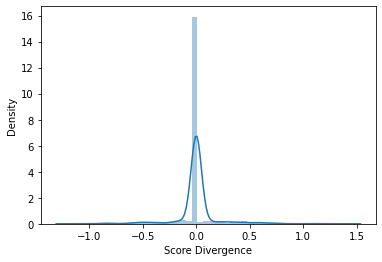

In [ ]:
fig = plt.figure('SES Divergence Scatter')
sns.jointplot(x='SES Ascent 2010-2019', y='SES Ascent 2010-2019 (Predicted)', data=predicted19ETR, kind='scatter')     
fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/SES Ascent 2010-2019-Divergence (Scatter)ETR.png', bbox_inches="tight")
plt.close()
print("Done.")

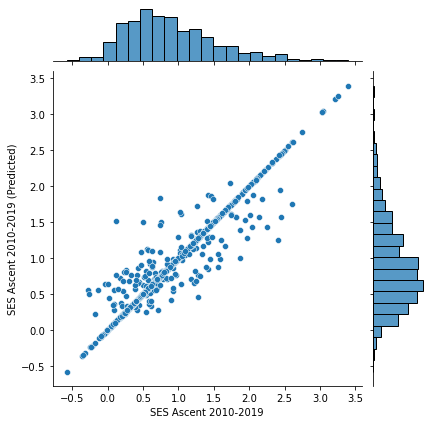

<h3>For the Random Forest Regressor</h3>

In [ ]:
fig = plt.figure('SES Divergence')
sns.distplot(predicted19RF['Score Divergence'], kde=True)      
fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/SES Ascent 2010-2019-DivergenceRF.png', bbox_inches="tight")
plt.close()
print("Done.")

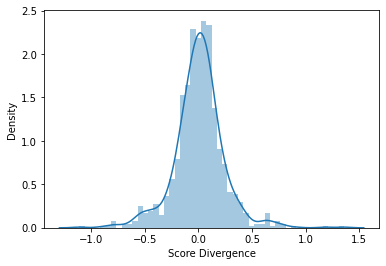

In [ ]:
fig = plt.figure('SES Divergence Scatter')
sns.jointplot(x='SES Ascent 2010-2019', y='SES Ascent 2010-2019 (Predicted)', data=predicted19RF, kind='scatter')     
fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/SES Ascent 2010-2019-Divergence (Scatter)RF.png', bbox_inches="tight")
plt.close()
print("Done.")

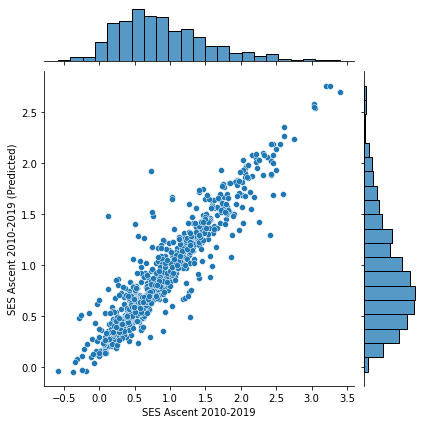

<h2>Make Predictions about the Future</h2>

<h3>For the Extra Trees Regressor</h3>

In [ ]:
#  Make future predictions
y_pred_28 = etr_clf.predict(d19_trs2)  #  Make predictions using data from 2019
predicted28 = pd.DataFrame({
        'geoid': pd.Series(d19_trs2.index),
        'SES Ascent 2019-2028 (Predicted)': pd.Series(y_pred_28)})
predicted28.set_index('geoid', inplace=True)

predicted28.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/Predicted Ascent 2019-2028' + to_use + 'ETR.csv', index=True)  #  Write results to csv
predicted28.sample(3, random_state=r_state)

In [ ]:
pdf = predicted19ETR.merge(predicted28, left_index=True, right_index=True, how='left')  #  Integrate SES 2028 predictions into SES score data
pdf['SES 2028 (Predicted)'] = pdf.loc[:,'SES 2019'] + pdf.loc[:,'SES Ascent 2019-2028 (Predicted)']  # Compute SES score in 2028

#  Compute rank in 2012
pdf['SES 2028 Percentile'] = pdf.loc[:,'SES 2028 (Predicted)'].rank(ascending=True, pct=True)*100

#  Compute change in LSOA ranking from 2019 to 2028
pdf['SES Percentile Ascent 2019-2028'] = pdf.loc[:,'SES 2028 Percentile'] \
                                          - pdf.loc[:,'SES 2019 Percentile']

pdf[['SES 2010','SES 2019','SES 2028 (Predicted)','SES Ascent 2010-2019','SES Ascent 2019-2028 (Predicted)']].sample(3, random_state=r_state)

In [ ]:
pdf.columns.values

In [ ]:
#  Write results to file
cols = ['SES 2010','SES 2019 (Predicted)','SES 2019','SES 2028 (Predicted)',
        'SES 2010 Percentile','SES 2019 Percentile','SES 2028 Percentile',
        'SES Ascent 2010-2019','SES Ascent 2010-2019 (Predicted)','SES Ascent 2019-2028 (Predicted)',
        'SES Percentile Ascent 2010-2019','SES Percentile Ascent 2019-2028',
        'Score Divergence','Ascent Divergence']

pdf = pdf[cols]
fcols = ['Score Divergence','Ascent Divergence']
pdf.loc[:, fcols] = pdf[fcols].astype(float).applymap('{0:.15f}'.format)

In [ ]:
pdf.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/Predicted' + to_use + 'ETR.csv', index=True)

<h3>For the Random Forest Regressor</h3>

In [ ]:
#  Make future predictions
y_pred_28 = rf_clf.predict(d19_trs2)  #  Make predictions using data from 2019
predicted28 = pd.DataFrame({
        'geoid': pd.Series(d19_trs2.index),
        'SES Ascent 2019-2028 (Predicted)': pd.Series(y_pred_28)})
predicted28.set_index('geoid', inplace=True)

predicted28.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/Predicted Ascent 2019-2028' + to_use + 'RF.csv', index=True)  #  Write results to csv
predicted28.sample(3, random_state=r_state)

In [ ]:
# For creating Predicted Values in Boston Alone
bos_tracts = pd.read_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/Census_2010_Tracts.csv', index_col = 0)
bos_tracts.rename(columns = {'GEOID10':'geoid'}, inplace = True)

pdf = predicted19RF.merge(predicted28, left_index=True, right_index=True, how='left')  #  Integrate SES 2028 predictions into SES score data
pdf_bos = predicted_bos.merge(predicted28, left_index=True, right_index=True, how='left')

pdf['SES 2028 (Predicted)'] = pdf.loc[:,'SES 2019'] + pdf.loc[:,'SES Ascent 2019-2028 (Predicted)']  # Compute SES score in 2028
pdf_bos['SES 2028 (Predicted)'] = pdf_bos.loc[:,'SES 2019'] + pdf_bos.loc[:,'SES Ascent 2019-2028 (Predicted)']  # Compute SES score in 2028

#  Compute rank in 2028
pdf['SES 2028 Percentile'] = pdf.loc[:,'SES 2028 (Predicted)'].rank(ascending=True, pct=True)*100
pdf_bos['SES 2028 Percentile'] = pdf_bos.loc[:,'SES 2028 (Predicted)'].rank(ascending=True, pct=True)*100

#  Compute change in LSOA ranking from 2019 to 2028
pdf['SES Percentile Ascent 2019-2028'] = pdf.loc[:,'SES 2028 Percentile'] \
                                          - pdf.loc[:,'SES 2019 Percentile']
pdf_bos['SES Percentile Ascent 2019-2028'] = pdf_bos.loc[:,'SES 2028 Percentile'] \
                                          - pdf_bos.loc[:,'SES 2019 Percentile']

pdf[['SES 2010','SES 2019','SES 2028 (Predicted)','SES Ascent 2010-2019','SES Ascent 2019-2028 (Predicted)']].sample(3, random_state=r_state)
pdf_bos[['SES 2010','SES 2019','SES 2028 (Predicted)','SES Ascent 2010-2019','SES Ascent 2019-2028 (Predicted)']].sample(3, random_state=r_state)

In [ ]:
pdf.columns.values

In [ ]:
pdf_bos.columns.values

In [ ]:
#  Write results to file
cols = ['SES 2010','SES 2019 (Predicted)','SES 2019','SES 2028 (Predicted)',
        'SES 2010 Percentile','SES 2019 Percentile','SES 2028 Percentile',
        'SES Ascent 2010-2019','SES Ascent 2010-2019 (Predicted)','SES Ascent 2019-2028 (Predicted)',
        'SES Percentile Ascent 2010-2019','SES Percentile Ascent 2019-2028',
        'Score Divergence','Ascent Divergence']

pdf = pdf[cols]
pdf_bos = pdf_bos[cols]

fcols = ['Score Divergence','Ascent Divergence']
pdf.loc[:, fcols] = pdf[fcols].astype(float).applymap('{0:.15f}'.format)
pdf_bos.loc[:, fcols] = pdf_bos[fcols].astype(float).applymap('{0:.15f}'.format)

In [ ]:
pdf.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/Predicted' + to_use + 'RF.csv', index=True)
pdf_bos.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/07-Neighborhood Predictions/Predicted Boston' + to_use + 'RF.csv', index=True)